In [1]:
from collections import defaultdict
from datetime import UTC, datetime, timedelta, timezone
from typing import Optional

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
from huggingface_hub import DatasetInfo, HfApi

/home/mtyrolski/dev/opengvl/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def filter_datasets_by_date(
    hub_api,
    created_after: str | None = None,
    modified_after: str | None = None,
    created_before: str | None = None,
    modified_before: str | None = None,
    task_categories: str | None = None,
    tags: list[str] | None = None,
    limit: int | None = None,
    sort_by: str = "created_at",
    descending: bool = True,
) -> list[DatasetInfo]:
    """Filter datasets by creation/modification dates."""

    def parse_date(date_str):
        if date_str is None:
            return None
        return datetime.fromisoformat(date_str.replace("Z", "+00:00")).replace(tzinfo=UTC)

    created_after_dt = parse_date(created_after)
    modified_after_dt = parse_date(modified_after)
    created_before_dt = parse_date(created_before)
    modified_before_dt = parse_date(modified_before)

    datasets = list(hub_api.list_datasets(task_categories=task_categories, tags=tags))

    filtered_datasets = []
    for dataset in datasets:
        if created_after_dt and dataset.created_at < created_after_dt:
            continue
        if created_before_dt and dataset.created_at > created_before_dt:
            continue
        if modified_after_dt and dataset.last_modified < modified_after_dt:
            continue
        if modified_before_dt and dataset.last_modified > modified_before_dt:
            continue
        filtered_datasets.append(dataset)

    if sort_by == "created_at":
        filtered_datasets.sort(key=lambda x: x.created_at, reverse=descending)
    elif sort_by == "last_modified":
        filtered_datasets.sort(key=lambda x: x.last_modified, reverse=descending)
    elif sort_by == "downloads":
        filtered_datasets.sort(key=lambda x: x.downloads or 0, reverse=descending)
    elif sort_by == "likes":
        filtered_datasets.sort(key=lambda x: x.likes or 0, reverse=descending)

    if limit:
        filtered_datasets = filtered_datasets[:limit]

    return filtered_datasets

In [3]:
def get_monthly_accumulation(hub_api: HfApi, start_date: str = "2025-01-01") -> tuple[list[str], list[int], dict]:
    """Get monthly accumulation of LeRobot datasets from start_date to today."""

    all_datasets = filter_datasets_by_date(
        hub_api,
        created_after=start_date,
        task_categories="robotics",
        tags=["LeRobot"],
        sort_by="created_at",
        descending=False,
    )

    def extract_episodes(dataset):
        # if hasattr(dataset, "episodes") and dataset.episodes is not None:
        #     return dataset.episodes
        desc = getattr(dataset, "description", "")
        for key in ["total_episodes", "num_episodes"]:
            idx = desc.find(f'"{key}":')
            if idx != -1:
                try:
                    val = int(desc[idx:].split(":", 1)[1].split(",")[0].strip().strip('"'))
                    return val
                except Exception:
                    continue
        return 0

    all_episodes = sum(extract_episodes(dataset) for dataset in all_datasets)
    print(f"Total episodes: {all_episodes}")
    start_dt = datetime.fromisoformat(start_date).replace(tzinfo=UTC)
    current_dt = datetime.now(UTC)

    month_labels = []
    current_month = start_dt.replace(day=1)

    while current_month <= current_dt:
        month_label = current_month.strftime("%Y-%m")
        month_labels.append(month_label)
        if current_month.month == 12:
            current_month = current_month.replace(year=current_month.year + 1, month=1)
        else:
            current_month = current_month.replace(month=current_month.month + 1)

    monthly_counts = defaultdict(int)
    monthly_datasets = defaultdict(list)

    for dataset in all_datasets:
        dataset_month_key = dataset.created_at.strftime("%Y-%m")
        monthly_counts[dataset_month_key] += 1
        monthly_datasets[dataset_month_key].append(dataset)

    cumulative_counts = []
    cumulative_total = 0
    detailed_data = {}

    for month_label in month_labels:
        month_count = monthly_counts[month_label]
        cumulative_total += month_count

        cumulative_counts.append(cumulative_total)

        detailed_data[month_label] = {
            "new_datasets": month_count,
            "cumulative_total": cumulative_total,
            "datasets": monthly_datasets[month_label],
        }

    return month_labels, cumulative_counts, detailed_data

In [4]:
def setup_plot_style():
    """Set up publication-ready plot styling."""
    plt.style.use("seaborn-v0_8-whitegrid")
    plt.rcParams.update(
        {
            "font.size": 11,
            "font.family": "serif",
            "font.serif": ["Times New Roman", "DejaVu Serif"],
            "axes.linewidth": 1.2,
            "axes.spines.left": True,
            "axes.spines.bottom": True,
            "axes.spines.top": False,
            "axes.spines.right": False,
            "xtick.direction": "in",
            "ytick.direction": "in",
            "xtick.major.size": 4,
            "ytick.major.size": 4,
            "grid.alpha": 0.3,
            "grid.linewidth": 0.8,
            "legend.frameon": True,
            "legend.framealpha": 0.9,
            "legend.facecolor": "white",
            "legend.edgecolor": "black",
        }
    )

In [ ]:
def plot_cumulative_growth(month_labels: list[str], cumulative_counts: list[int], save_path: str | None = None):
    """Create cumulative dataset growth plot."""
    setup_plot_style()

    month_dates = [datetime.strptime(label, "%Y-%m") for label in month_labels]

    _, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Enhanced cumulative plot
    ax.plot(
        month_dates,
        cumulative_counts,
        marker="o",
        linewidth=2.5,
        markersize=7,
        color="#2E86AB",
        markerfacecolor="white",
        markeredgewidth=2,
        markeredgecolor="#2E86AB",
        label="Cumulative Datasets",
    )

    # Add subtle fill under curve
    ax.fill_between(month_dates, cumulative_counts, alpha=0.2, color="#2E86AB")

    ax.set_title("LeRobot Dataset Growth on Hugging Face", fontsize=16, fontweight="bold", pad=20)
    ax.set_xlabel("Time Period", fontsize=12, fontweight="bold")
    ax.set_ylabel("Cumulative Number of Datasets", fontsize=12, fontweight="bold")
    ax.grid(True, alpha=0.4, linestyle="-", linewidth=0.5)

    # Enhanced annotations - only show every 3rd point to avoid clutter
    for i, (date, count) in enumerate(zip(month_dates, cumulative_counts, strict=False)):
        if i % 3 == 0 or i == len(month_dates) - 1:
            ax.annotate(
                f"{count}",
                (date, count),
                textcoords="offset points",
                xytext=(0, 12),
                ha="center",
                fontsize=9,
                fontweight="bold",
                bbox={"boxstyle": "round,pad=0.3", "facecolor": "white", "edgecolor": "#2E86AB", "alpha": 0.8},
            )

    # Enhanced x-axis formatting
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

    # Add summary statistics box
    total_datasets = cumulative_counts[-1] if cumulative_counts else 0
    stats_text = f"Total Datasets: {total_datasets}"
    ax.text(
        0.02,
        0.98,
        stats_text,
        transform=ax.transAxes,
        fontsize=11,
        verticalalignment="top",
        bbox={"boxstyle": "round,pad=0.5", "facecolor": "lightgray", "alpha": 0.8},
    )

    plt.tight_layout()

    if save_path:
        base_path = save_path.replace(".png", "") + "_cumulative"
        plt.savefig(f"{base_path}.png", dpi=300, bbox_inches="tight", facecolor="white")
        plt.savefig(f"{base_path}.pdf", bbox_inches="tight", facecolor="white")
        plt.savefig(f"{base_path}.svg", bbox_inches="tight", facecolor="white")
        print(f"Cumulative plot saved as: {base_path}.{{png,pdf,svg}}")

    plt.show()

In [ ]:
def plot_monthly_additions(month_labels: list[str], detailed_data: dict, save_path: str | None = None):
    """Create monthly dataset additions bar chart."""
    setup_plot_style()

    month_dates = [datetime.strptime(label, "%Y-%m") for label in month_labels]
    monthly_new = [detailed_data[label]["new_datasets"] for label in month_labels]

    _, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Create gradient colors for bars
    colors = plt.cm.viridis([x / max(monthly_new) if max(monthly_new) > 0 else 0 for x in monthly_new])

    bars = ax.bar(month_dates, monthly_new, alpha=0.8, color=colors, width=20, edgecolor="black", linewidth=0.8)

    ax.set_title("Monthly LeRobot Dataset Additions", fontsize=16, fontweight="bold", pad=20)
    ax.set_xlabel("Time Period", fontsize=12, fontweight="bold")
    ax.set_ylabel("New Datasets Added", fontsize=12, fontweight="bold")
    ax.grid(True, alpha=0.4, axis="y", linestyle="-", linewidth=0.5)

    # Enhanced x-axis formatting
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

    # Enhanced bar annotations
    for bar, count in zip(bars, monthly_new, strict=False):
        if count > 0:
            height = bar.get_height()
            ax.annotate(
                f"{count}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=9,
                fontweight="bold",
                bbox={"boxstyle": "round,pad=0.2", "facecolor": "white", "edgecolor": "gray", "alpha": 0.7},
            )

    # Add summary statistics box
    avg_monthly = sum(monthly_new) / len(monthly_new) if monthly_new else 0
    max_monthly = max(monthly_new) if monthly_new else 0

    stats_text = f"Avg/Month: {avg_monthly:.1f}\nPeak Month: {max_monthly}"
    ax.text(
        0.02,
        0.98,
        stats_text,
        transform=ax.transAxes,
        fontsize=11,
        verticalalignment="top",
        bbox={"boxstyle": "round,pad=0.5", "facecolor": "lightgray", "alpha": 0.8},
    )

    plt.tight_layout()

    if save_path:
        base_path = save_path.replace(".png", "") + "_monthly"
        plt.savefig(f"{base_path}.png", dpi=300, bbox_inches="tight", facecolor="white")
        plt.savefig(f"{base_path}.pdf", bbox_inches="tight", facecolor="white")
        plt.savefig(f"{base_path}.svg", bbox_inches="tight", facecolor="white")
        print(f"Monthly plot saved as: {base_path}.{{png,pdf,svg}}")

    plt.show()

In [7]:
def plot_accumulation(month_labels: list[str], cumulative_counts: list[int], detailed_data: dict, save_path: str | None = None):
    """Create both cumulative and monthly plots separately."""
    plot_cumulative_growth(month_labels, cumulative_counts, save_path)
    plot_monthly_additions(month_labels, detailed_data, save_path)

In [ ]:
def print_monthly_summary(detailed_data: dict):
    """Print a detailed monthly summary of dataset accumulation."""

    print("\n" + "=" * 80)
    print("LEROBOT DATASET ACCUMULATION SUMMARY")
    print("=" * 80)

    total_datasets = 0
    for _, data in detailed_data.items():
        total_datasets = data["cumulative_total"]

    print(f"Total LeRobot datasets (June 2024 - present): {total_datasets}")
    print(f"Analysis period: {len(detailed_data)} months")
    print("\nMonthly Breakdown:")
    print("-" * 60)

    for month, data in detailed_data.items():
        new_count = data["new_datasets"]
        cumulative = data["cumulative_total"]

        if new_count > 0:
            print(f"{month}: +{new_count:2d} new datasets (total: {cumulative:3d})")
            for _i, dataset in enumerate(data["datasets"][:3]):
                print(f"  • {dataset.id}")
            if len(data["datasets"]) > 3:
                print(f"  • ... and {len(data['datasets']) - 3} more")
        else:
            print(f"{month}:  {new_count:2d} new datasets (total: {cumulative:3d})")

    monthly_counts = [data["new_datasets"] for data in detailed_data.values()]
    avg_monthly = sum(monthly_counts) / len(monthly_counts)
    max_monthly = max(monthly_counts)
    max_month = next(month for month, data in detailed_data.items() if data["new_datasets"] == max_monthly)

    print("\nGrowth Statistics:")
    print("-" * 30)
    print(f"Average datasets per month: {avg_monthly:.1f}")
    print(f"Peak month: {max_month} ({max_monthly} datasets)")
    print(f"Months with no new datasets: {monthly_counts.count(0)}")


def get_recent_lerobot_datasets(hub_api, days_back=30):
    """Get LeRobot datasets created in the last N days"""
    cutoff_date = (datetime.now(UTC) - timedelta(days=days_back)).isoformat()

    return filter_datasets_by_date(
        hub_api,
        created_after=cutoff_date,
        task_categories="robotics",
        tags=["LeRobot"],
        sort_by="created_at",
        descending=True,
    )


def get_updated_lerobot_datasets(hub_api, days_back=7):
    """Get LeRobot datasets updated in the last N days"""
    cutoff_date = (datetime.now(UTC) - timedelta(days=days_back)).isoformat()

    return filter_datasets_by_date(
        hub_api,
        modified_after=cutoff_date,
        task_categories="robotics",
        tags=["LeRobot"],
        sort_by="last_modified",
        descending=True,
    )


def print_dataset_info(datasets):
    """Helper function to print dataset information"""
    for i, dataset in enumerate(datasets, 1):
        print(f"{i}. {dataset.id}")
        print(f"   Created: {dataset.created_at.strftime('%Y-%m-%d %H:%M:%S UTC')}")
        print(f"   Modified: {dataset.last_modified.strftime('%Y-%m-%d %H:%M:%S UTC')}")
        print(f"   Downloads: {dataset.downloads}, Likes: {dataset.likes}")
        print()

Analyzing LeRobot dataset accumulation from June 2024...
Total episodes: 2169347

LEROBOT DATASET ACCUMULATION SUMMARY
Total LeRobot datasets (June 2024 - present): 12647
Analysis period: 7 months

Monthly Breakdown:
------------------------------------------------------------
2025-03: +927 new datasets (total: 927)
  • wxj77/aloha_test_1
  • wxj77/aloha_test_2
  • wxj77/aloha_test_4
  • ... and 924 more
2025-04: +1575 new datasets (total: 2502)
  • aiwhisperer/test2
  • Chojins/chess_game_001_blue_stereo
  • hu-po/eval_pickup_cube
  • ... and 1572 more
2025-05: +1745 new datasets (total: 4247)
  • kwangchaeko/eval_act_koch_test_080000
  • kwangchaeko/eval_act_koch_test_100000
  • kwangchaeko/eval_act_koch_test_020000
  • ... and 1742 more
2025-06: +2851 new datasets (total: 7098)
  • gxy1111/eval_act_soft_dinov2
  • un1c0rnio/so101_test
  • shenjianliang/play_game
  • ... and 2848 more
2025-07: +2702 new datasets (total: 9800)
  • jackvial/editor-test-3
  • drck007/blue-test-1
  • jac

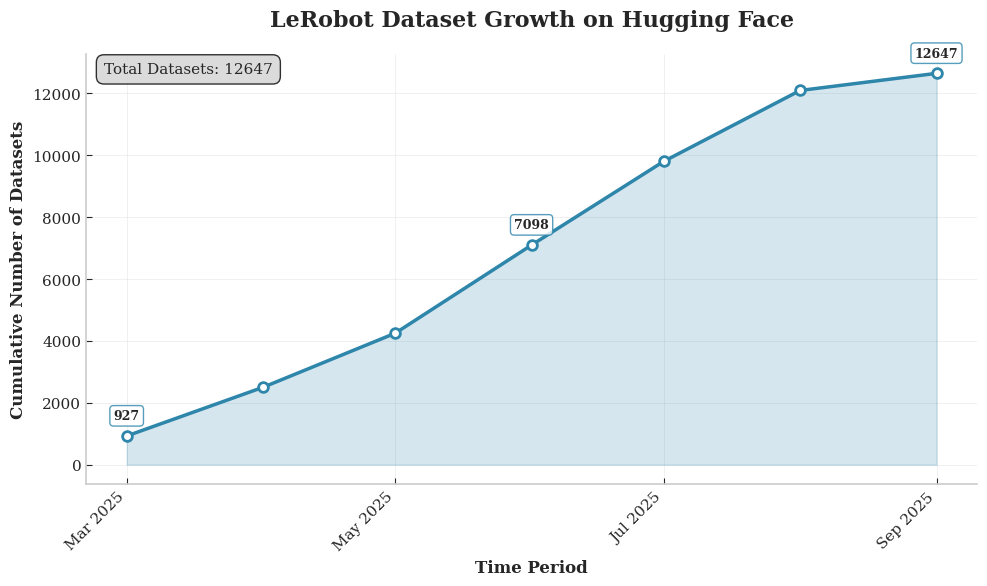

Monthly plot saved as: lerobot_dataset_accumulation_monthly.{png,pdf,svg}


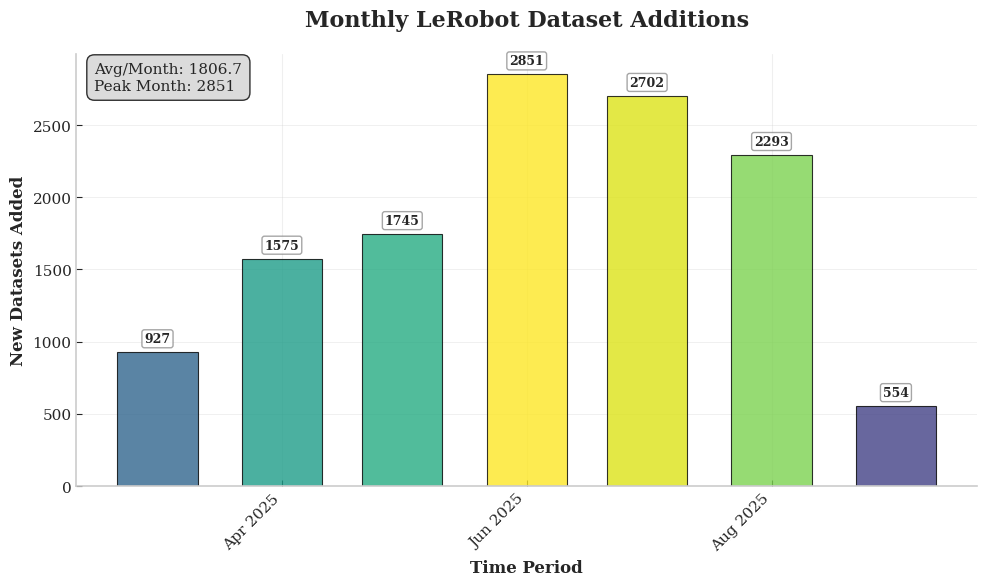


Data saved to: lerobot_accumulation_data.csv


In [9]:
print("Analyzing LeRobot dataset accumulation from June 2024...")

hub_api = HfApi()

month_labels, cumulative_counts, detailed_data = get_monthly_accumulation(hub_api, start_date="2025-03-01")

print_monthly_summary(detailed_data)

plot_accumulation(month_labels, cumulative_counts, detailed_data, save_path="lerobot_dataset_accumulation.png")

df_data = []
for month, data in detailed_data.items():
    df_data.append({"month": month, "new_datasets": data["new_datasets"], "cumulative_total": data["cumulative_total"]})

df = pd.DataFrame(df_data)
df.to_csv("lerobot_accumulation_data.csv", index=False)
print("\nData saved to: lerobot_accumulation_data.csv")